# Data Processing - Overlap Scans

## Notes on this notebook

In [1]:
# run using dev install of EDA:
# github.com/vsihlab/eda
# commit ID: [TODO, downstream from v0.1.1]

## Imports and global variables

In [2]:
# General imports
import json
import pickle

from IPython.display import display
from lmfit import report_fit
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import eda.analysis.dataframe_plotting as dfplot
import eda.data_io.csv_to_dataframe as csv2df

In [3]:
# GLOBAL UNITS: 
# time: ps
# b-field: mT
# voltages: V

# FIGURE DIMENSIONS FOR PRIVATE USE VS REPO:
# FIG_SIZE_MULT = 4  # normal use
FIG_SIZE_MULT = 2.5  # smaller version for repo notebooks

FONT_SCALE = FIG_SIZE_MULT / 2.5

In [4]:
# Optional: import jtplot to make figures match jupyterthemes config
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=FONT_SCALE)
    # set the default figure size
    jtplot.figsize(x=FIG_SIZE_MULT * 2.5, y=FIG_SIZE_MULT * 2.5)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

## Load data

In [5]:
load_option = 'b'

### Option A: Load already-processed data

In [6]:
if load_option == 'a':
    # REQUIRED: actual coordinate scanned in data
    scan_coordinate_column = "Mirror Position (um)"

    # REQUIRED: input filepaths
    input_dataframe_filepath = "./processed_dataframe.csv"
    input_metadata_list_filepath = "./processed_metadata_list.json"

    with open(input_dataframe_filepath, 'r') as f:
        full_dataframe = pd.read_csv(f, sep='\t',
                                     index_col=[0, 1, 2])
    with open(input_metadata_list_filepath, 'r') as f:
        file_metadata_list = json.load(f)

    # plot newly created dataframe and show the first few rows
    figure_size = (FIG_SIZE_MULT * 3, FIG_SIZE_MULT * 1.5)
    num_waterfall_plots = 4
    data_column = 'kerr_rotation'
    x_values_column = 'probe_delay'
    y_values_column = None
    xlabel = 'Pump-Probe Delay (ps)'
    ylabel = None
    imshow_kwargs = {'aspect': 1.0,
                     'origin': 'upper'}
    plt.figure(figsize=figure_size)
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    dfplot.plot_dataframe_colorplot(full_dataframe, data_column,
                                    x_values_column, y_values_column,
                                    xlabel=xlabel, ylabel=ylabel,
                                    ax=ax1, **imshow_kwargs)
    dfplot.plot_dataframe_waterfall(full_dataframe, data_column,
                                    num_waterfall_plots,
                                    x_values_column, y_values_column,
                                    xlabel=xlabel, ylabel=None, ax=ax2)
    ax2.yaxis.set_ticklabels([])
    plt.show()
    display(full_dataframe.head(5))

### Option B: Load and process raw data

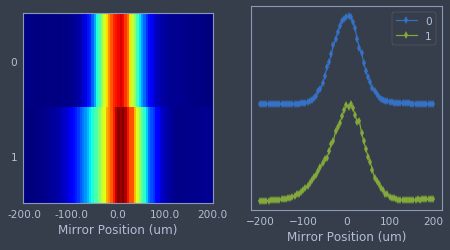

mirror_pos   lockin1  kerr_rotation  file_index  \
run_id index_2d index_1d                                                    
0      11.0     0             -200.0  0.001661        0.00574           0   
                1             -195.0  0.001721        0.00530           0   
                2             -190.0  0.001697        0.00582           0   
                3             -185.0  0.001571        0.00600           0   
                4             -180.0  0.001674        0.00658           0   

                          probe_delay  wavelength  
run_id index_2d index_1d                           
0      11.0     0               100.0       836.0  
                1               100.0       836.0  
                2               100.0       836.0  
                3               100.0       836.0  
                4               100.0       836.0

In [7]:
if load_option == 'b':
    # REQUIRED: columns & labels used to plot data.
    # may be present in the raw data or defined somewhere
    # below. If column is renamed below, this variable
    # will also be updated to reflect the new name.
    scan_coordinate_column = "Mirror Position (um)"
    measured_value_column = "kerr_rotation"
    scan_coordinate_label = "Mirror Position (um)"

    # REQUIRED: output filenames
    output_dataframe_filename = "processed_dataframe.csv"
    output_metadata_list_filename = "processed_metadata_list.json"
    output_image_filename = "processed_dataframe_plot.png"

    # REQUIRED: data directory
    parent_dir = ('.')

    # REQUIRED: data storage format information
    delimiter = '\t'
    trailing_delimiters = True  # rows end in delimiters
    num_headerlines = 0
    column_names_row = 1  # NOT counting skipped lines from num_headerlines
    overwriting_column_names = []

    if not overwriting_column_names:
        overwriting_column_names = None
    pandas_read_csv_kwargs = {
         'skiprows': num_headerlines,
         'header': column_names_row,
         'names': overwriting_column_names,
         'delimiter': delimiter,
    }
    if trailing_delimiters:  # needed to avoid problems
        pandas_read_csv_kwargs['index_col'] = False

    # REQUIRED: filename key for data files, will load only these
    filename_key = '.dat'

    # REQUIRED: criteria for grouping runs
    run_criteria = 'directory'

    # OPTIONAL: filepath parsing rules
    # DEFAULT SEARCH TERMS AND SEARCH RULES:
    # 1. If first string found, register second string as
    #    tag containing third string/value
    #        e.g. if keyword_list contains ("warmup", "Warmup?", "Yes"):
    #             "...warmup..." -> {"Warmup?": "Yes"}
    this_element_keyword_list = [
        (       "CISP", "Experiment Type", "CISP"       ),
        ( "Delay_Scan", "Experiment Type", "Delay_Scan" ),
        ( "Field_Scan", "Experiment Type", "Field_Scan" ),
        ("Mirror_Scan", "Experiment Type", "Mirror_Scan"),
        ( "RMBE1130-K", "Sample ID", "RMBE1130-K"),
        ("[1-10]Horiz", "Sample Orientation", "[1-10]Horiz"),
    ]
    # 2. Grab next element(s) if this one CONTAINS first string,
    #    tag next element(s) as second string(s)
    #        e.g. "..._Ind_3_..." -> {"FastScanIndex": 3}
    #        e.g. "..._2Dscan_MirrorY_MirrorZ_..."
    #                 -> {"SecondScanType": "MirrorY",
    #                     "FirstScanType": "MirrorZ"}
    next_element_keyword_list = []
    # 3. Grab this element if it CONTAINS first string,
    #    tag remainder as second string
    #        e.g. "..._30K_..." -> {"SetTemperature": 30}
    in_this_element_keyword_list = [
        ("FIELD", "Date_and_Scan_2D_Index"),
        ("DLAY", "Date_and_Scan_2D_Index"),
        ("STPR", "Date_and_Scan_2D_Index"),
        ("phi-", "Electric Field Angle"),
        ("T", "Magnetic Field (T)"),
        ("K", "Set Temperature (K)"),
        ("nm", "Wavelength (nm)"),
        ("ps", "Delay Time (ps)"),
        ("V", "Voltage (V)"),
    ]
    parsing_keyword_lists = [this_element_keyword_list,
                             next_element_keyword_list,
                             in_this_element_keyword_list]

    # OPTIONAL: metadata processing functions,
    # must accept dict and modify in-place
    def derive_metadata_from_scan_type_tag(metadata_dict):
        if 'Date_and_Scan_2D_Index' in metadata_dict.keys():
            date_and_index = str(metadata_dict['Date_and_Scan_2D_Index'])
            metadata_dict['Date'] = date_and_index[:6]
            metadata_dict['Scan_2D_Index'] = float(date_and_index[6:]) - 1
            del metadata_dict['Date_and_Scan_2D_Index']
    def consolidate_aliases_for_bfield(metadata_dict):
        if 'Magnetic Field (T)' in metadata_dict.keys():
            metadata_dict['Magnetic Field (mT)'] = \
                1000.0 * metadata_dict['Magnetic Field (T)']
            del metadata_dict['Magnetic Field (T)']
    metadata_processing_fcns = [derive_metadata_from_scan_type_tag,
                                consolidate_aliases_for_bfield]

    # OPTIONAL: metadata-based filtering fcns, type: dict() -> bool
    # fcns returning False if data should be ignored
    metadata_filter_fcns = [
        lambda metadata_dict: \
            "alignment" not in metadata_dict.get("Filepath"),
    #     lambda metadata_dict: \
    #         metadata_dict.get("# repeats", 1) <= 2,
        lambda metadata_dict: \
            "Scan_2D_Index" in metadata_dict.keys(),
    ]

    # OPTIONAL: metadata tags to be converted to dataframe columns.
    # Elements should be of form ('metadata tag', 'column name')
    metadata_tag_to_column_list = [
        (              'Run ID', 'run_id'),
        (       'Scan_2D_Index', 'index_2d'),
        (     'Delay Time (ps)', 'probe_delay'),
        ('Mirror Position (um)', 'mirror_pos'),
        ( 'Magnetic Field (mT)', 'b_external'),
        (     'Wavelength (nm)', 'wavelength'),
        (         'Voltage (V)', 'voltage'),
    ]

    # OPTIONAL: dictionary describing column names to rewrite,
    # whether derived from metadata or not. By default,
    # includes the above dictionary's aliases. Also,
    # update the column names above
    # Key:value pairs should be of form 'old name':'new name'
    column_renaming_dict = \
        {key:val for key, val in metadata_tag_to_column_list}
    column_renaming_dict.update({
        'Mirror Position (um)': 'mirror_pos',
               'Lock-In 1 (V)': 'lockin1',
               'Lock-In 2 (V)': 'kerr_rotation',
    })
    if scan_coordinate_column in column_renaming_dict:
        scan_coordinate_column = \
            column_renaming_dict[scan_coordinate_column]
    if measured_value_column in column_renaming_dict:
        measured_value_column = \
            column_renaming_dict[measured_value_column]

    # OPTIONAL: dataframe processing functions,
    # must accept dataframe and modify in-place
    def set_dataframe_indices(df):
        df['index_1d'] = df.index  # assumes index = 0,1,2,...  
        df.set_index(['run_id', 'index_2d', 'index_1d'],
                     drop=True, append=False, inplace=True)
#     # not needed, handled by consolidate_aliases_for_bfield 
#     def rescale_magnetic_field(df):  # 
#         if 'Magnetic Field (T)' in list(df):
#             df['Magnetic Field (mT)'] = 1000.0 * df['Magnetic Field (T)']
#             del df['Magnetic Field (T)']
    def edit_dataframe_colnames(df):  # should usually be last
        filtered_renaming_dict = \
            {key: val for (key, val) in column_renaming_dict.items()
             if key in list(df)}
        df.rename(columns=filtered_renaming_dict, inplace=True)
    dataframe_processing_fcns = [
        set_dataframe_indices,
        edit_dataframe_colnames,
    ]

    file_dataframes_list, file_metadata_list = \
        csv2df.process_directory_csvs_to_dataframes(
            parent_dir, filename_key, run_criteria,
            pandas_read_csv_kwargs,
            parsing_keyword_lists,
            metadata_processing_fcns,
            metadata_filter_fcns,
            metadata_tag_to_column_list,
            dataframe_processing_fcns)

    full_dataframe = pd.concat(file_dataframes_list)
    full_dataframe.sort_index(ascending=True, inplace=True)

    # Save processed dataframe & metadata to file
    with open(output_dataframe_filename, 'w') as f:
        full_dataframe.to_csv(f, sep='\t')
    with open(output_metadata_list_filename, 'w') as f:
        json.dump(file_metadata_list, f)

    # plot newly created dataframe and show the first few rows
    figure_size = (FIG_SIZE_MULT * 3, FIG_SIZE_MULT * 1.5)
    num_waterfall_plots = 4
    data_column = measured_value_column
    x_values_column = scan_coordinate_column
    y_values_column = None
    xlabel = scan_coordinate_label
    ylabel = None
    imshow_kwargs = {'aspect': 1.0,
                     'origin': 'upper'}
    plt.figure(figsize=figure_size)
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    dfplot.plot_dataframe_colorplot(full_dataframe, data_column,
                                    x_values_column, y_values_column,
                                    xlabel=xlabel, ylabel=ylabel,
                                    ax=ax1, **imshow_kwargs)
    dfplot.plot_dataframe_waterfall(full_dataframe, data_column,
                                    num_waterfall_plots,
                                    x_values_column, y_values_column,
                                    xlabel=xlabel, ylabel=None, ax=ax2)
    ax2.yaxis.set_ticklabels([])
    plt.savefig(output_image_filename,
                bbox_inches='tight',
                transparent=False)
    plt.show()
    display(full_dataframe.head(5))

In [8]:
# TAKE A LOOK AT ANY SUBFILE
file_index = 0
for key, val in file_metadata_list[file_index].items():
    print("{}: {}".format(key, val))
file_dataframes_list[file_index].head()

Set Temperature (K): 30.0
File Last Modified: Sun Aug 20 00:27:14 2017
Filepath: .\170606STPR12 Mirror_Scan RMBE1130-K_30K_100ps_836nm_[1-10]Horiz_PumpSens10mV_Axis1.dat
Sample Orientation: [1-10]Horiz
Sample ID: RMBE1130-K
Wavelength (nm): 836.0
Scan_2D_Index: 11.0
Date: 170606
Delay Time (ps): 100.0
Run ID: 0


mirror_pos   lockin1  kerr_rotation  file_index  \
run_id index_2d index_1d                                                    
0      11.0     0             -200.0  0.001661        0.00574           0   
                1             -195.0  0.001721        0.00530           0   
                2             -190.0  0.001697        0.00582           0   
                3             -185.0  0.001571        0.00600           0   
                4             -180.0  0.001674        0.00658           0   

                          probe_delay  wavelength  
run_id index_2d index_1d                           
0      11.0     0               100.0       836.0  
                1               100.0       836.0  
                2               100.0       836.0  
                3               100.0       836.0  
                4               100.0       836.0

In [9]:
# # EXAMPLE - REORDERING AXES
# df = full_dataframe
# df = df.groupby(level=[-3, -2]).head(5)
# new_index = df.index.reorder_levels([-2, -3, -1])
# df.index = new_index
# df.head()

## Dataset fit model and residuals

In [10]:
# GLOBAL CONSTANTS
GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
LASER_REPRATE = 13158  # ps period

from eda.analysis.fit_tools import create_residuals_fcn

def overlap_gaussian_fcn(mirror_pos, gaussian_amp, spot_width,
                         pos_offset, slope, offset):
    expo = (0.5 * np.power(mirror_pos - pos_offset, 2)
            / np.power(spot_width / np.sqrt(2), 2))
    output = gaussian_amp * np.exp( -1 * expo)
    output += slope * mirror_pos + offset
    return output

overlap_gaussian_residuals = \
    create_residuals_fcn(overlap_gaussian_fcn, ['mirror_pos'])

## Dataset fit parameter setup and constraints

In [11]:
from lmfit import Parameters

params_guesses = [('gaussian_amp',        {'value' : 0.4,
                                           'min'   : 0.2,
                                           'max'   : 0.5}),
                  ('spot_width',          {'value' : 55.0,
                                           'min'   : 20.0,
                                           'max'   : 100.0,
                                           'vary'  : True}),
                  ('pos_offset',          {'value' : 0.0,
                                           'min'   : -1e3,
                                           'max'   : +1e3}),
                  ('slope',               {'value' : 0.0,
                                           'min'   : -1e2,
                                           'max'   : +1e2}),
                  ('offset',              {'value' : 0.0,
                                           'min'   : -1e2,
                                           'max'   : +1e2}),
                 ]
fit_params = Parameters()
for param_name, param_guess_dict in params_guesses:
    fit_params.add(param_name, **param_guess_dict)

## Fit all datasets (1D)

file_index  probe_delay  wavelength  gaussian_amp  \
run_id index_2d                                                      
0.0    11.0             0.0        100.0       836.0      0.377870   
       12.0             1.0        100.0       836.0      0.386801   

                 gaussian_amp_error  spot_width  spot_width_error  pos_offset  \
run_id index_2d                                                                 
0.0    11.0                0.001448   46.130822          0.219265    0.110642   
       12.0                0.004954   57.203278          0.935810    2.375311   

                 pos_offset_error     slope  slope_error    offset  \
run_id index_2d                                                      
0.0    11.0              0.141884  0.000007     0.000003  0.006582   
       12.0              0.589276 -0.000030     0.000014  0.011271   

                 offset_error  result_index    chisqr    redchi  
run_id index_2d                                                  
0.0    11.0          0.000568             0  0.001134  0.000015  
       12.0          0.002342             1  0.015834  0.000208

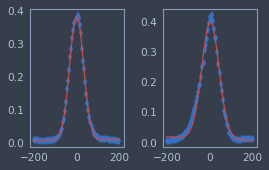

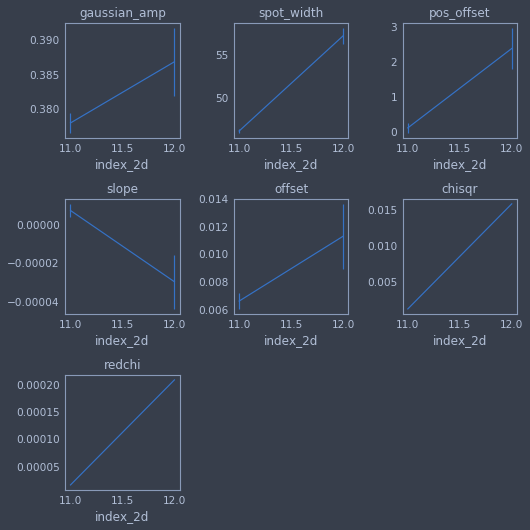

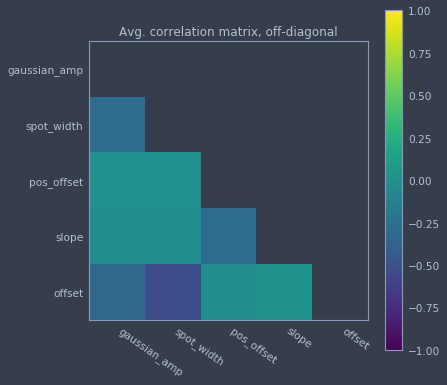

In [12]:
from eda.analysis.dataframe_processing \
    import df_minimize_fcn_on_datasets

df = full_dataframe
residuals_fcn = overlap_gaussian_residuals
fit_params = fit_params
independent_vars_columns = ["mirror_pos"]
measured_data_column = measured_value_column
column_aggregation_dict = {}  # needed to keep cols w/ non-const values
keep_const_columns = True

output_fit_results_dataframe_filename = "fit_results_dataframe.csv"
output_fit_minimize_results_filename = "fit_minimize_results.pickle"
output_fit_vs_data_image_filename = "fit_results_fit_vs_data.png"
output_fit_params_image_filename = "fit_results_fit_params.png"
output_fit_covariances_image_filename = "fit_results_covariances.png"

# Fit!
minimize_results, results_df = \
    df_minimize_fcn_on_datasets(
        df, residuals_fcn, fit_params,
        independent_vars_columns,
        measured_data_column,
        column_aggregation_dict=column_aggregation_dict,  # keywords only!
#        method='nelder',
        keep_const_columns=keep_const_columns,
    )

# add minimizer result attributes to results_df
attributes_to_add = ['chisqr', 'redchi']
for attribute in attributes_to_add:
    attribute_list = []
    for result in minimize_results:
        attribute_list.append(getattr(result, attribute))
    results_df[attribute] = attribute_list

# Display fit params dataframe & save to file
with open(output_fit_results_dataframe_filename, 'w') as f:
    results_df.to_csv(f, sep='\t')
with open(output_fit_minimize_results_filename, 'wb') as f:
    pickle.dump(minimize_results, f)
display(results_df.head(5))

# plot fits
ncols = 4
nplots = len(minimize_results)
nrows = np.int(np.ceil(nplots / ncols))
plt.figure(figsize=(FIG_SIZE_MULT * 3, FIG_SIZE_MULT * nrows))
for result_index in list(range(nplots)):
    ax = plt.subplot(nrows, ncols, result_index + 1)
    result = minimize_results[result_index]
    dataset_index = results_df.index[result_index]
    xvals = df.loc[dataset_index][scan_coordinate_column]
    yvals = df.loc[dataset_index][measured_data_column]
    indep_vars_vecs = [df.loc[dataset_index][colname]
                       for colname in independent_vars_columns]
    fit_yvals = residuals_fcn(result.params, *indep_vars_vecs)
    ax.plot(xvals, yvals, 'bd', label='dataset {}'.format(result_index))
    ax.plot(xvals, fit_yvals, 'r')
    plt.tight_layout()
plt.savefig(output_fit_vs_data_image_filename,
            bbox_inches='tight',
            transparent=False)

# plot params
params_to_plot_list = result.var_names + attributes_to_add
ncols = 3
nplots = len(params_to_plot_list)
nrows = np.int(np.ceil(nplots / ncols))
plt.figure(figsize=(FIG_SIZE_MULT * 3, FIG_SIZE_MULT * nrows))
for ind, param in enumerate(params_to_plot_list):
    ax = plt.subplot(nrows, ncols, ind + 1)
    if (param + '_error') in list(results_df):
        ax.errorbar(x=results_df.index.get_level_values(-1),
                    y=results_df[param],
                    yerr=results_df[param + '_error'])
    else:
        ax.plot(results_df.index.get_level_values(-1),
                results_df[param].values)
    plt.xlabel(results_df.index.names[-1])
    plt.tight_layout()
    plt.title(param)
plt.savefig(output_fit_params_image_filename,
            bbox_inches='tight',
            transparent=False)

# Plot the avg. covariance matrix
corr_mats = []
for result in minimize_results:
    covar = result.covar
    oostd = np.diagflat([1.0 / param.stderr
                         for param in list(result.params.values())
                         if param.name in result.var_names])
    corr = np.dot(np.dot(oostd, result.covar), oostd)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan
    corr_mats.append(corr)
avgcorr = np.mean(corr_mats, axis=0)
plt.figure()
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(np.arange(result.nvarys), result.var_names,
           rotation=-35, ha='left')
plt.yticks(np.arange(result.nvarys), result.var_names)
plt.title('Avg. correlation matrix, off-diagonal')
plt.savefig(output_fit_covariances_image_filename,
            bbox_inches='tight',
            transparent=False)
plt.show()


----------------------------------------


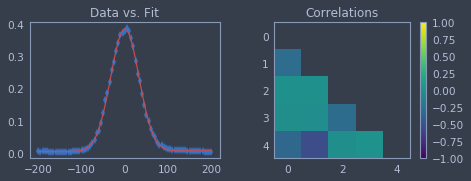

FIT #1
run_id: 0.0
index_2d: 11.0
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 81
    # variables        = 5
    chi-square         = 0.001
    reduced chi-square = 0.000
    Akaike info crit   = -895.276
    Bayesian info crit = -883.304
[[Variables]]
    gaussian_amp:   0.37786953 +/- 0.001448 (0.38%) (init= 0.4)
    spot_width:     46.1308221 +/- 0.219264 (0.48%) (init= 55)
    pos_offset:     0.11064199 +/- 0.141884 (128.24%) (init= 0)
    slope:          7.0003e-06 +/- 3.45e-06 (49.22%) (init= 0)
    offset:         0.00658244 +/- 0.000568 (8.62%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(spot_width, offset)        = -0.447 
    C(gaussian_amp, spot_width)  = -0.372 
    C(gaussian_amp, offset)      = -0.277 
    C(pos_offset, slope)         = -0.211 


None

----------------------------------------


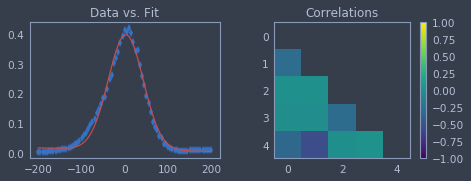

FIT #2
run_id: 0.0
index_2d: 12.0
[[Fit Statistics]]
    # function evals   = 33
    # data points      = 81
    # variables        = 5
    chi-square         = 0.016
    reduced chi-square = 0.000
    Akaike info crit   = -681.743
    Bayesian info crit = -669.771
[[Variables]]
    gaussian_amp:   0.38680078 +/- 0.004953 (1.28%) (init= 0.4)
    spot_width:     57.2032779 +/- 0.935810 (1.64%) (init= 55)
    pos_offset:     2.37531072 +/- 0.589276 (24.81%) (init= 0)
    slope:         -3.0024e-05 +/- 1.41e-05 (46.99%) (init= 0)
    offset:         0.01127117 +/- 0.002342 (20.78%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(spot_width, offset)        = -0.524 
    C(gaussian_amp, offset)      = -0.334 
    C(pos_offset, slope)         = -0.291 
    C(gaussian_amp, spot_width)  = -0.288 


None

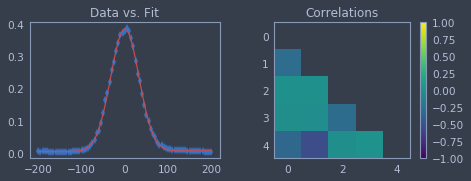

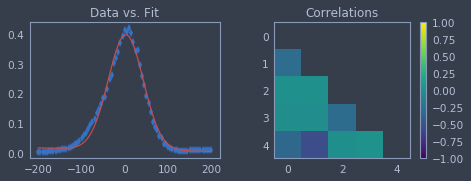

In [13]:
# DETAILED FIT REPORTS
for result_index, result in enumerate(minimize_results):
    print('----------------------------------------')
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False,
                                   figsize=(FIG_SIZE_MULT * 3,
                                            FIG_SIZE_MULT * 1))
    dataset_index = results_df.index[result_index]
    xvals = df.loc[dataset_index][scan_coordinate_column]
    yvals = df.loc[dataset_index][measured_data_column]
    indep_vars_vecs = [df.loc[dataset_index][colname]
                       for colname in independent_vars_columns]
    fit_yvals = residuals_fcn(result.params, *indep_vars_vecs)
    ax1.plot(xvals, yvals, 'bd', label='dataset {}'.format(result_index))
    ax1.plot(xvals, fit_yvals, 'r')
    ax1.set_title('Data vs. Fit')
    img = ax2.imshow(corr, vmin=-1, vmax=1)
    fig.colorbar(img, ax=ax2)
    ax2.set_title('Correlations')
    display(fig)
    print('FIT #{}'.format(result_index + 1))
    for col, val in zip(results_df.index.names,
                        results_df.index[result_index]):
        print('{}: {}'.format(col, val))
    display(report_fit(result))